This notebook gives an example of how to use the CarrierCapture code to compute carrier capture coefficient and capture cross section in semiconductors.

# 0. Defect calculation

Before we start to use CarrierCapture, we need to obtain equilibrium defect configurations and their thermodynamic transition levels. 


# 1. Potential energy surface (PES)

- The datapoints (i.e. deformed structures) are generated by a linear interpolation between equilibrium configurations of excited (initial) and ground (final) states, which can be obtained by [gen_cc_struct.py](https://github.com/WMD-group/CarrierCapture.jl/blob/master/script/gen_cc_struct.py), or using the convenience functions in [`doped.utils.configurations`](https://doped.readthedocs.io/en/latest/doped.utils.html#module-doped.utils.configurations). It is important for these structures to have matching orientations/positions (such that they correspond to the shortest linear path between them; i.e. having the defect located in the same position in the supercells and similarly oriented) -- this is automatically ensured using the `doped` functions.

- The PES is plotted as a function of one-dimensional (1D) generalised configuration coordinate *Q*, which can be obtained by [get_del_Q.py](https://github.com/WMD-group/CarrierCapture.jl/blob/master/script/get_del_Q.py), or again through python using the convenience functions in [`doped.utils.configurations`](https://doped.readthedocs.io/en/latest/doped.utils.html#module-doped.utils.configurations). $\Delta Q$ is a collective variable of the mass-weighted deformation $\Delta Q =\sum m \Delta R$.

- Make sure all datapoints used for fitting are in-gap localised states. This can be checked via eigenvalue vs Q plot (by [get_eig.py](https://github.com/WMD-group/CarrierCapture.jl/blob/master/script/get_eig.py), and/or using the [`doped` eigenvalue analysis methods](https://doped.readthedocs.io/en/latest/advanced_analysis_tutorial.html#eigenvalue-electronic-structure-analysis).

In [ ]:
using CarrierCapture
using Plots, LaTeXStrings
using DataFrames
@show VERSION

In [ ]:
delQ = 8.07 # delta Q between the ground and excited structures
Qmin = -25
Qmax = 35   # make sure all relevent wave functions are in the domain
NQ = 3000
Q = range(Qmin, stop=Qmax, length=NQ)

### $V_{Sb}^{+}$ $\leftrightarrow$ $V_{Sb}^{0}$

In [ ]:
V_Sb2_pl1_dis_energies =
[
-306.49288985
-308.67901366
-309.92726295
-310.59027963
-310.89085604
-310.95113718
-310.96857068
-310.95277540
-310.91157405
-310.77696631
-310.60179886
-310.41102036
-310.22131229
-310.04202954
-309.87524902
-309.71410834
-309.54286080
-309.34089029
]

V_Sb2_pl1_disp_Q = [-1.0 -0.8 -0.6 -0.4 -0.2 -0.1 0 0.1 0.2 0.4 0.6 0.8 1.0 1.2 1.4 1.6 1.8 2.0]

V_Sb2_neu_dis_energies =
[
-305.32288767
-305.51394841
-305.64936072
-305.73855057
-305.78965975
-305.80253419
-305.80709261
-305.80329650
-305.79080662
-305.73757288
-305.64328303
-305.51321657
]
V_Sb2_neu_dis_energies_discard = [-305.46018465]

V_Sb2_neu_disp_Q = [-1.0 -0.8 -0.6 -0.4 -0.2 -0.1 0 0.1 0.2 0.4 0.6 0.8]
V_Sb2_neu_disp_Q_discard = [1.0]

Here we use `spline` interpolation (which is the recommended one) to find the best fit for PES. Other available options are `bspline`, `harmonic`, `polyfunc` and `morse`. For more details, see [Potential.jl](https://github.com/WMD-group/CarrierCapture.jl/blob/master/src/Potential.jl)

In [ ]:
# pot1
nev = 175   # make sure you include enough number of states to describe the carrier-cature behaviour
name = L"V_{Sb}^+\ + e^{\-}_{ CBM} + h^{\+}_{ VBM}\ \ (^{}$$"
Q1 = V_Sb2_pl1_disp_Q  * delQ
#Q1_d = V_Se1_pl2_disp_Q_discard * delQ
E1 = V_Sb2_pl1_dis_energies
#E1_d = V_Se1_pl2_dis_energies_discard

pot1 = Potential(); pot1.name = name
pot1.nev = nev
pot1.Q0 = Q1[findmin(E1)[2]]; pot1.E0 = 1.42  # the value of fundamental band gap
pot1.QE_data = DataFrame(Q = Q1[:], E = E1[:])
pot1.QE_data.E .+= - minimum(pot1.QE_data.E) + pot1.E0
pot1.Q = Q

pot1.func_type = "spline"
fit_pot!(pot1)

# pot2
name = L"V_{Sb}^0\ + h^{\+}_{ VBM}  \ \ (^{}$$"
Q2 = V_Sb2_neu_disp_Q  * -delQ .+ delQ
Q2_d = V_Sb2_neu_disp_Q_discard * -delQ .+ delQ
E2 = V_Sb2_neu_dis_energies
E2_d = V_Sb2_neu_dis_energies_discard

pot2 = Potential(); pot2.name = name
pot2.nev = nev
pot2.Q0 = Q2[findmin(E2)[2]]; pot2.E0 = 1.161 # the value of thermodynamic transition level
pot2.QE_data = DataFrame(Q = Q2[:], E = E2[:])
pot2.QE_data.E .+= - minimum(pot2.QE_data.E) + pot2.E0
pot2.Q = Q
pot2.func_type = "spline"
fit_pot!(pot2)


# pot3
name = L"V_{Sb}^+ \ \ (^{}$$"

pot3 = Potential(); pot3.name = name
pot3.nev = nev
pot3.Q0 = Q1[findmin(E1)[2]]; pot3.E0 = 0
pot3.QE_data = DataFrame(Q = Q1[:], E = E1[:])
pot3.QE_data.E .+= - minimum(pot3.QE_data.E) + pot3.E0
pot3.Q = Q

pot3.func_type = "spline"
fit_pot!(pot3)

"fitting completed"

The next step is solving the 1D Schrödinger equation for each PES to obtain their phonon (nuclear) wavefunctions.

In [ ]:
solve_pot!(pot1)
solve_pot!(pot2)
solve_pot!(pot3)
"Schrödinger equation solved"

The classical energy barrier to capture an electron or a hole can be calculated using the `find_crossing` function.

In [ ]:
Qx, Ex = find_crossing(pot2, pot3)
println("Hole capture barrier: $(Ex-pot2.E0) eV")
Qx, Ex = find_crossing(pot1, pot2)
println("Electron capture barrier: $(Ex-pot1.E0) eV")

In [ ]:
plt = plot(legendfontsize=10,legend=:topright,yaxis = font(12),xaxis = font(12))
Plotter.plot_pot!(pot1; lplt_wf = true, plt = plt, color = "#b2182b")
Plotter.plot_pot!(pot2; lplt_wf = true, plt = plt, color = "#2166ac")
Plotter.plot_pot!(pot3; lplt_wf = true, plt = plt, color = "#b2182b")
Plotter.scatter!(Q2_d, E2_d .-minimum(E2) .+ pot2.E0, plt = plt, label="", color = "#52faf7")
xlims!((-10, 18))
ylims!((-0.5, 5.5))

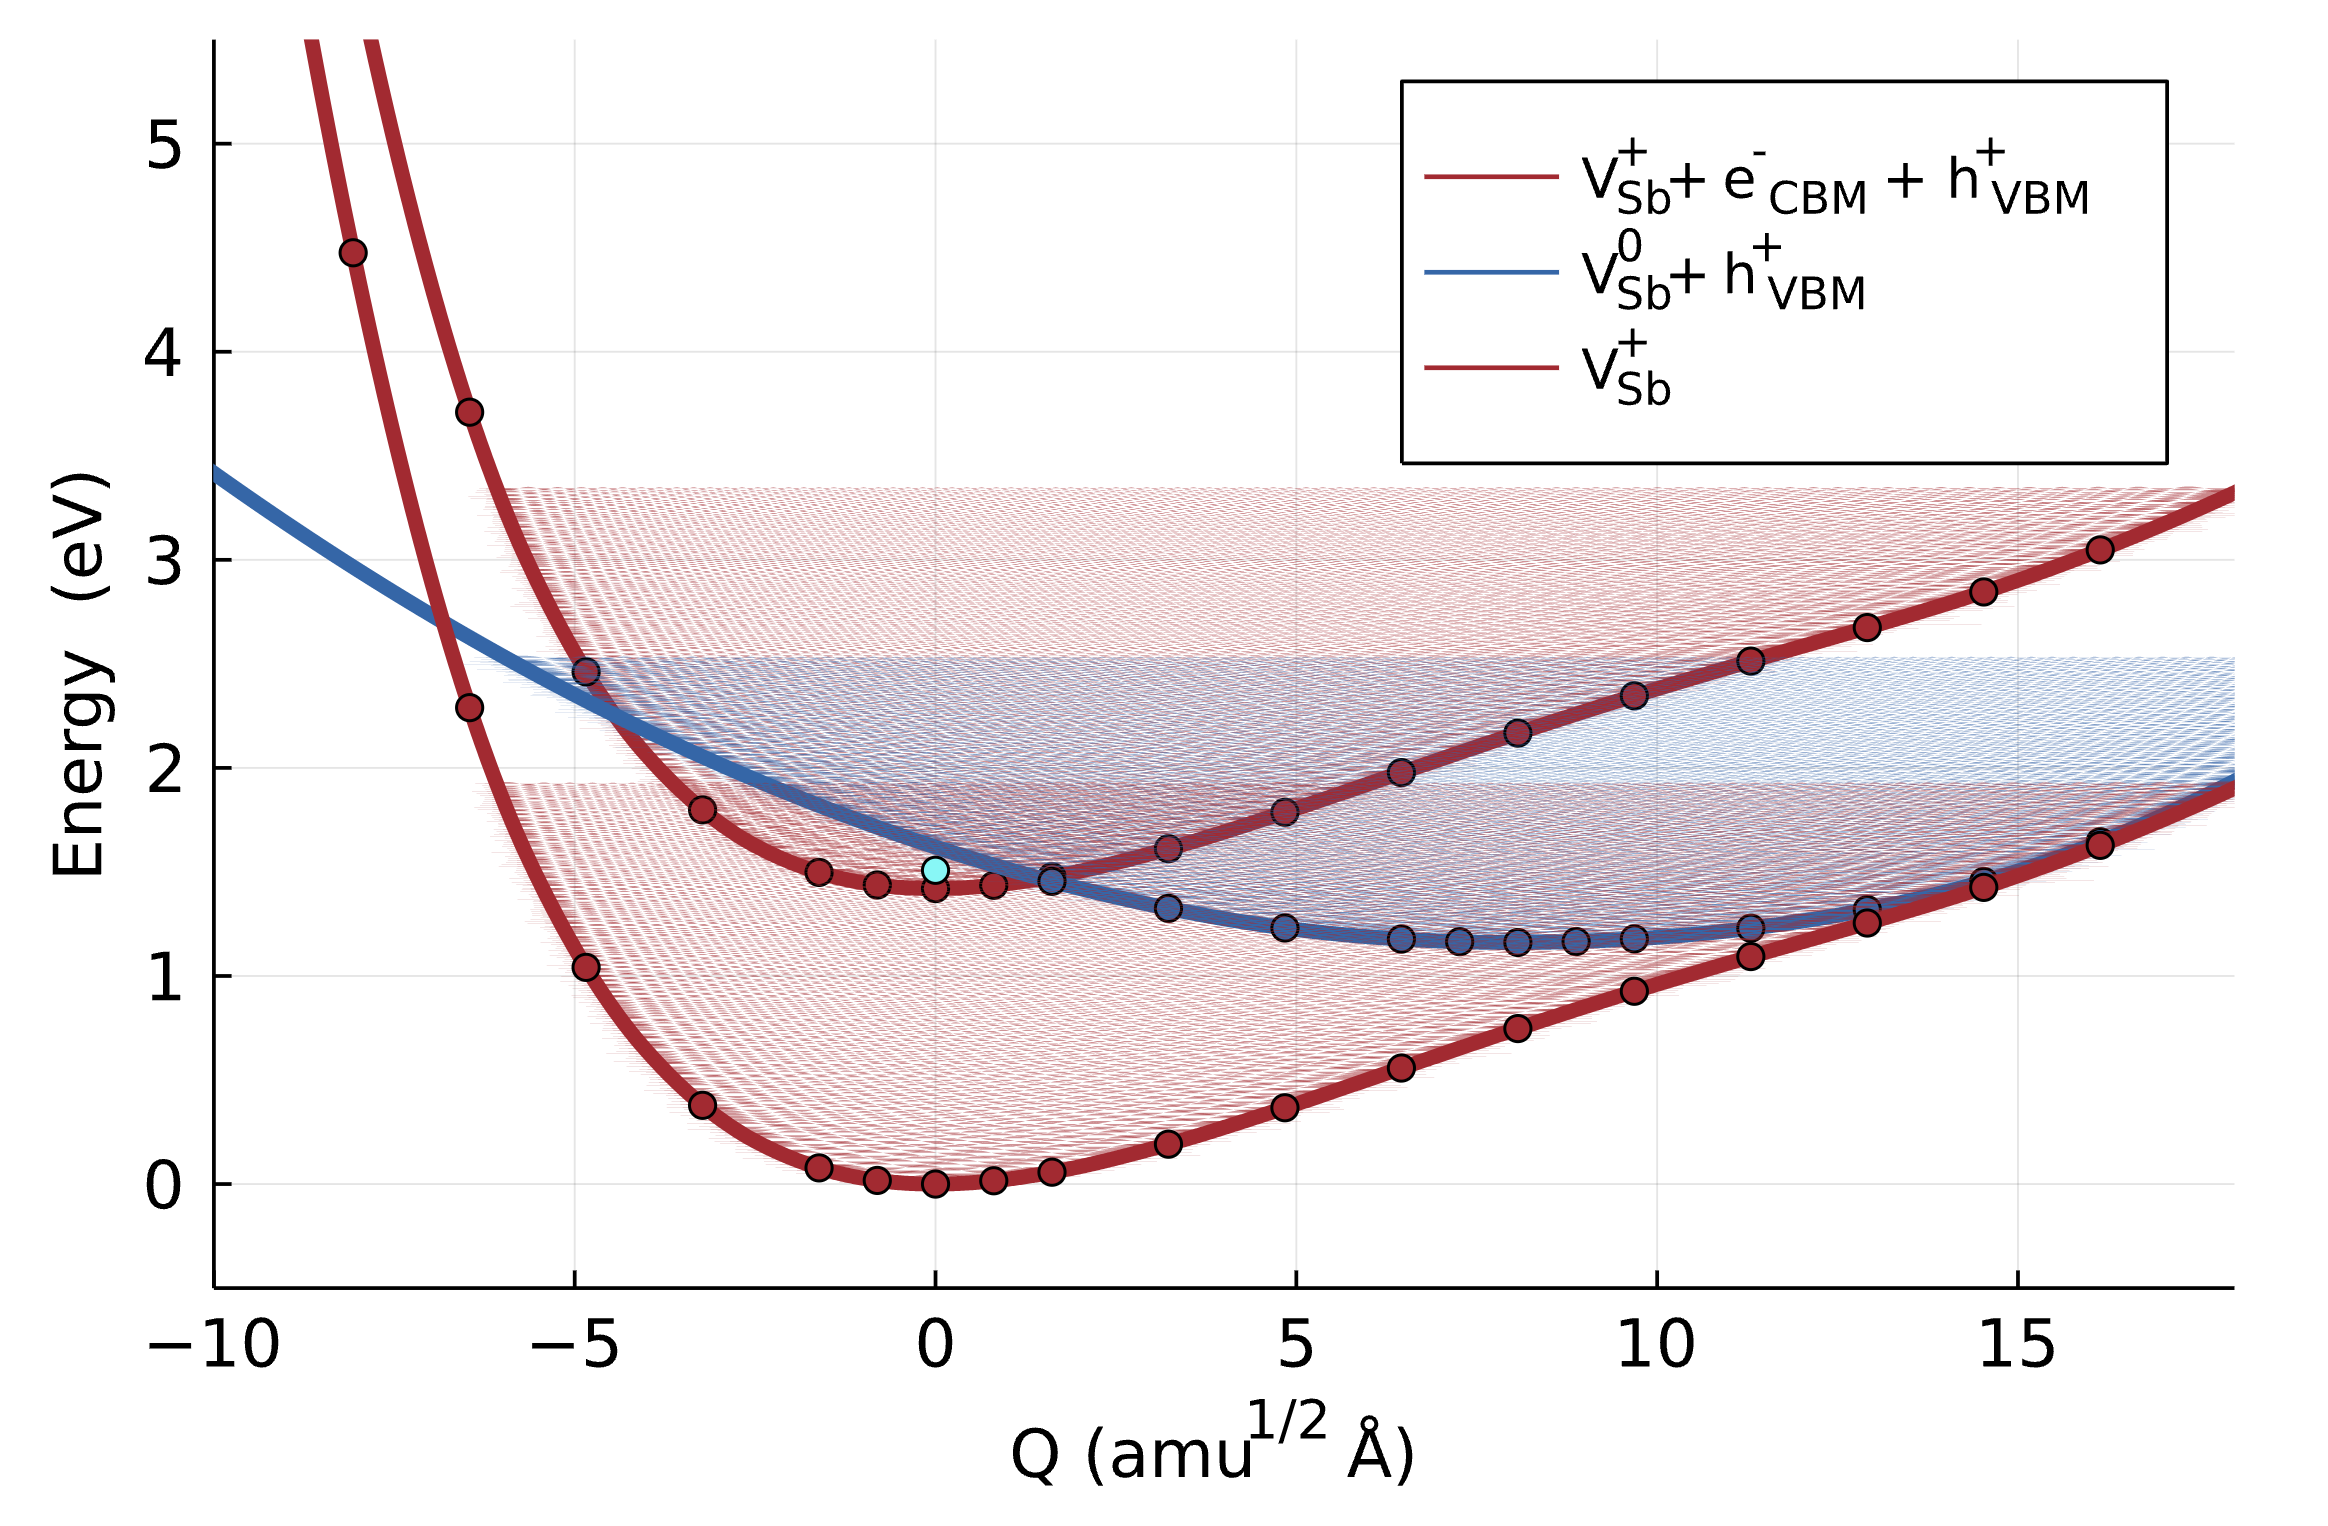

# 2. Capture coefficient and cross section

## 2.1 Electron-phonon (e-ph) coupling matrix element


- The e-ph coupling matrix element is given by 


$$W_{if} = (ε_f - ε_i) {d <ψ_i(0)|ψ_f(Q)> \over dQ}$$

Where *i* corresponds to a perturbed band-edge state, and *f* corresponds to a localised defect state. *ε* is the KS eigenvalue.


- The overlap of  wavefunctions can either be calculated by [PAWpySeed](https://pypi.org/project/pawpyseed/#description) or VASP

### Method 1: PAWpySeed

The overlap ⟨𝜓<sub>𝑖</sub>(0)|𝜓<sub>f</sub>(𝑄)⟩ can be calculated by [get_wf.py](https://github.com/WMD-group/CarrierCapture.jl/blob/master/script/get_wf.py):

$ python get_wf.py -d <band_index of ψ_i> -b <band_index of ψ_f>  -D <path to the initial geometry> -i <path to the deformed geometry 1> [<path to the deformed geometry 2> ...]  -k <kpoint index> -s <0 for spin-unpolarised and 1 for spin-polarised calculation>


### Method 2: WSWQ method implemented in VASP (recommended)

- The reference `WAVECAR` used for WSWQ calculations corresponds to {*Q*$_0$}. The single most important criterion to choose *Q*$_0$ is that, in the configuration {*Q*$_0$} a single-particle defect level should be well defined and be in the bulk band gap. For more details, see [this paper](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.90.075202).


- For each *Q*:
 - copy `POSCAR`, `INCAR`, `POTCAR`, `KPOINTS` and the reference `WAVECAR` to a new folder. 
 - copy the `WAVECAR` from each {*Q*} configuration to the new folder and rename it to `WAVECAR.qqq`.
 - set `LWSWQ = True` and `ALGO=None` in the `INCAR` file.
 - output `WSWQ` file.
 
 
- Make sure your fitting datapoints as linear as possible, since what we calculate is the slope of the overlap ⟨𝜓<sub>𝑖</sub>(0)|𝜓<sub>f</sub>(𝑄)⟩ as a function of *Q*.

In [ ]:
macro javascript_str(s) display("text/javascript", s); end   #change kernel from julia to python

In [ ]:
javascript"""
Jupyter.notebook.session.restart({kernel_name: 'python3'})
"""

### Hole capture

In [ ]:
# use neutral structure and datapoints of disp_002,004,006
import matplotlib as mpl
import matplotlib.pyplot as plt
from nonrad.ccd import get_Q_from_struct
from nonrad.elphon import get_Wif_from_WSWQ
from pathlib import Path
from pymatgen.core.structure import Structure
from glob import glob

cc_dir = "/path/to/cc_dir/"

V_Sb_002 = Structure.from_file(f"{cc_dir}/disp_002/CONTCAR")
V_Sb_004 = Structure.from_file(f"{cc_dir}/disp_004/CONTCAR")
V_Sb_006 = Structure.from_file(f"{cc_dir}/disp_006/CONTCAR")

WSWQs = []
for d in glob(f"{cc_dir}/disp_*"): 
        if d[-3:] in ["002", "004", "006"]:
            pd = Path(d)
            Q = get_Q_from_struct(V_Sb_004, V_Sb_006, f"{pd}/CONTCAR")
            path_wswq = f"{pd}/LWSWQ_2/WSWQ"
            WSWQs.append((Q, path_wswq))
        
fig = plt.figure(figsize=(12, 5))
ground_vr_path = f"{cc_dir}/disp_004/vasprun.xml" 

Wifs = get_Wif_from_WSWQ(WSWQs, ground_vr_path, 166, 165, spin=1, fig=fig) 

plt.tight_layout()
plt.ylim(-0.11,0.22)
plt.show()

In [ ]:
Wifs

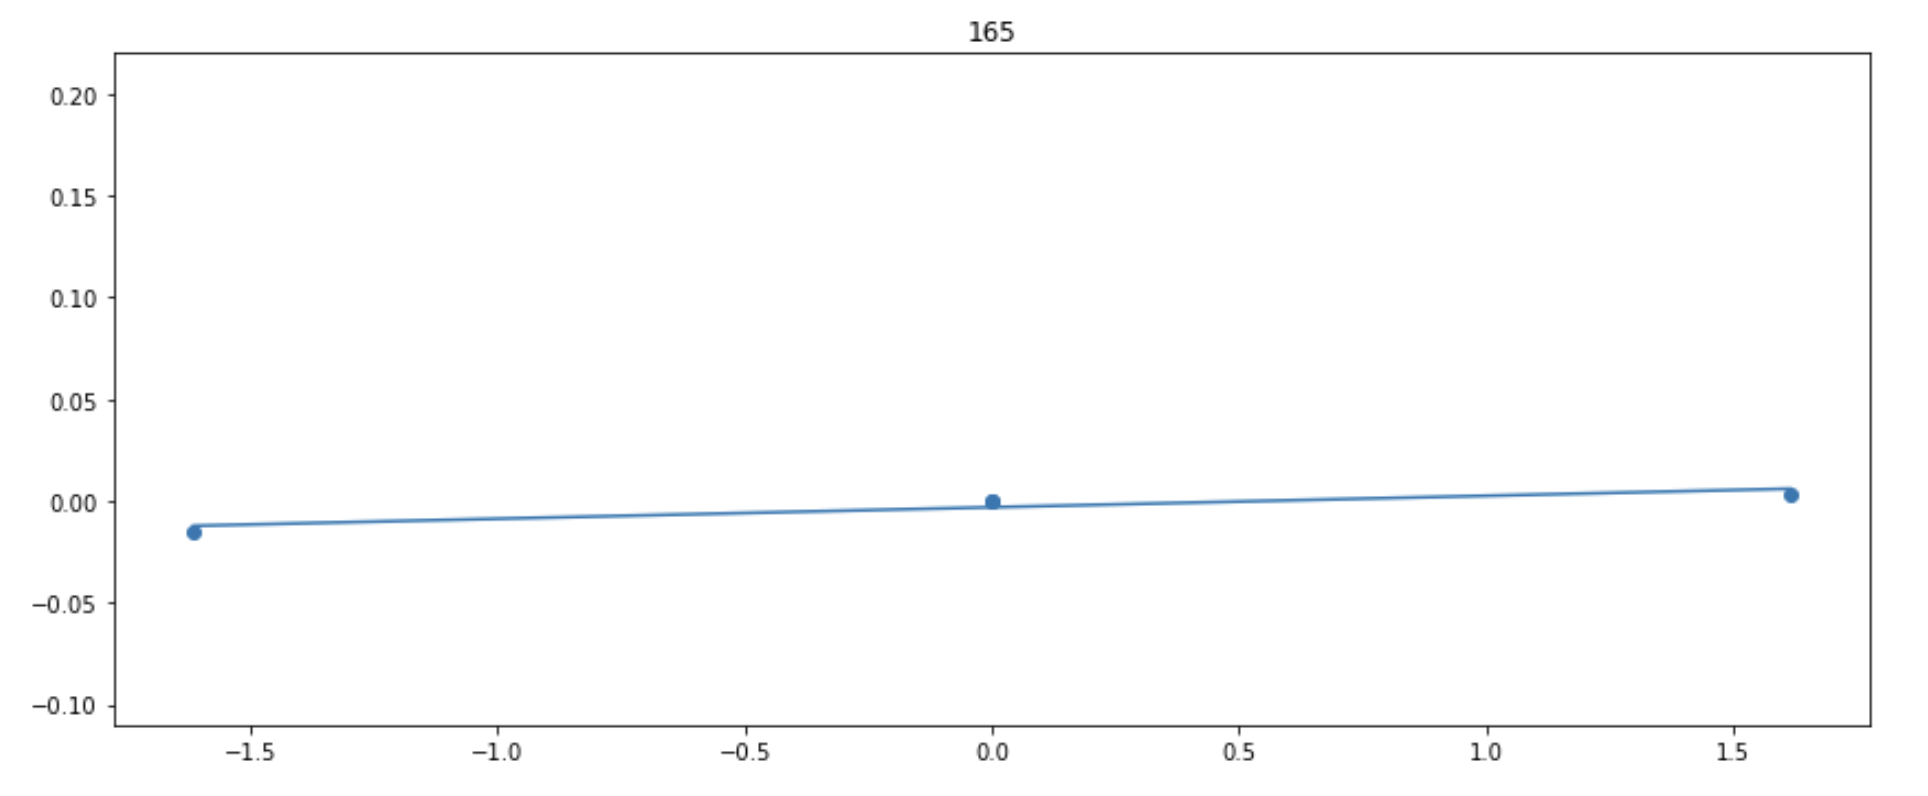

### Electron capture

In [ ]:
# use neutral structure and datapoints of disp_002,004,006
cc_dir = "/path/to/cc_dir/"

V_Sb_002 = Structure.from_file(f"{cc_dir}/disp_002/CONTCAR")
V_Sb_004 = Structure.from_file(f"{cc_dir}/disp_004/CONTCAR")
V_Sb_006 = Structure.from_file(f"{cc_dir}/disp_006/CONTCAR")


WSWQs = []
for d in glob(f"{cc_dir}/disp_*"): 
        if d[-3:] in [ "002", "004", "006" ]:
            pd = Path(d)
            Q = get_Q_from_struct(V_Sb_004, V_Sb_006, f"{pd}/CONTCAR")
            path_wswq = f"{pd}/LWSWQ_2/WSWQ"
            WSWQs.append((Q, path_wswq))
        
        
fig = plt.figure(figsize=(12, 5))
ground_vr_path = f"{cc_dir}/disp_004/vasprun.xml" 


Wifs = get_Wif_from_WSWQ(WSWQs, ground_vr_path, 166, 167, spin=0, kpoint=3, fig=fig) 

plt.tight_layout()
plt.ylim(-0.04,0.07)
plt.show()

In [ ]:
Wifs

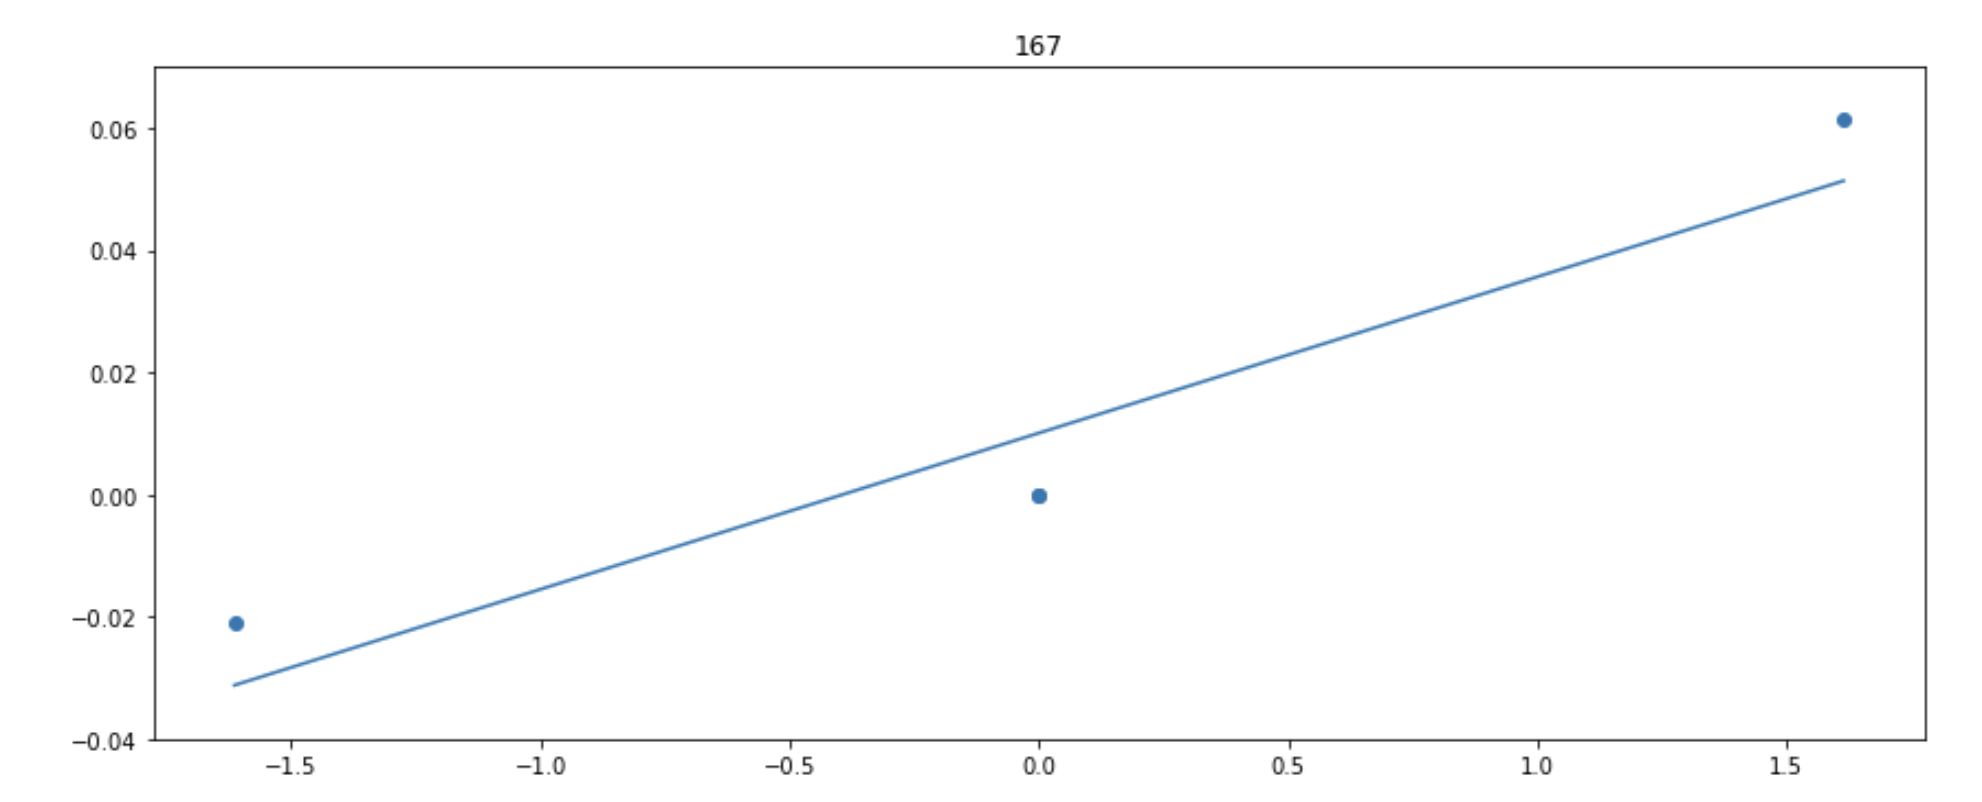

## 2.2 Scaling factors

### 2.2.1 Sommerfeld parameter

- If the carrier is captured by a charged defect, Sommerfeld parameter which accounts for the Coulombic interaction between the carrier and defect should be considered.


- Input parameters include:
    - $Z = q_d/q_c$, where $q_d$ and $q_c$ correspond to the charge of the defect and carrier, respectively.
    - Hole and electron effective masses
    - Dielectric constant

### Electron capture by $V_{Sb}^{+}$

In [ ]:
macro javascript_str(s) display("text/javascript", s); end   #change kernel from julia to python

In [ ]:
javascript"""
Jupyter.notebook.session.restart({kernel_name: 'python3'})
"""

In [ ]:
from nonrad.scaling import sommerfeld_parameter
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

T = np.linspace(10, 800, 100)

Z = -1 # q_d/q_c
m_e_Sb2Se3 = 0.35
m_h_Sb2Se3 = 0.90
ϵ_0_Sb2Se3 = 76.27

f_e = sommerfeld_parameter(T, Z, m_e_Sb2Se3, ϵ_0_Sb2Se3)

plt.subplots(dpi=100)
plt.plot(T, f_e)

In [ ]:
for i in f_e: #   copy and paste below
    print(i, end=", ")

### 2.2.2 Charged supercell effects

- If a *charged* supercell is used to calculate e-ph coupling matrix elements, an interaction between the defect and delocalised band edge due to the finite-size supercell appears. For more details, see [this paper](https://doi.org/10.1016/j.cpc.2021.108056).


- In the example shown above, we used $V_{Sb}^{0}$ to calculate e-ph coupling matrix elements, so no charged supercell correction is needed. But if we use $V_{Sb}^{+}$ instead, we need to include this correction term:

### Hole capture

In [ ]:
from nonrad.scaling import charged_supercell_scaling_VASP
import matplotlib.pyplot as plt

wavecar_path = str("/path/to/WAVECAR")

fig = plt.figure(figsize=(12, 5))
factor = charged_supercell_scaling_VASP(wavecar_path, 165, def_index=166, fig=fig)
plt.tight_layout()
plt.show()

print('scaling =', 1 /factor) 

### Electron capture

In [ ]:
from nonrad.scaling import charged_supercell_scaling_VASP
import matplotlib.pyplot as plt

wavecar_path = str("/path/to/WAVECAR")

fig = plt.figure(figsize=(12, 5))
factor = charged_supercell_scaling_VASP(wavecar_path, 167, def_index=166, fig=fig)
plt.tight_layout()
plt.show()

print('scaling =', 1 /factor)

## 2.3 Capture coefficient

In [ ]:
%%javascript
Jupyter.notebook.session.restart({kernel_name: 'julia-1.6'}) 

In [ ]:
Tmin = 10
Tmax = 800
NT = 100
Volume = 1.63305E-21
cut_off = 0.25
σ = 0.01
temperature = range(Tmin, stop=Tmax, length=NT)

### Hole capture by $V_{Sb}^{0}$

In [ ]:
# use neutral structure - spin-up
Q₀ = 0.6 * delQ
W_h = 0.008845542513718841 # e-ph coupling
g_h =  1 # degeneracy of the final state

# build a configuration coordinate for the hole capture
cc_h = conf_coord(pot2, pot3)
cc_h.W = W_h
cc_h.g = g_h
calc_overlap!(cc_h; cut_off = cut_off, σ = σ, Q₀ = Q₀)
calc_capt_coeff!(cc_h, Volume, temperature)

In [ ]:
plt = plot(legendfontsize=12,legend=:right,yaxis = font(12),xaxis = font(12))
plot!(plt, cc_h.temperature, cc_h.capt_coeff, lw = 4, label = "Hole Capture")
vline!(plt, [300], linestyle=:dash, lw=2,label=false,color=:grey)
xaxis!(L"\ T (K) \ (^{}$$");
ylims!(1E-16, 1E-8)
yaxis!(L"C (cm^{3}\/s) \ (^{}$$", :log10)
xlims!(20, 750)

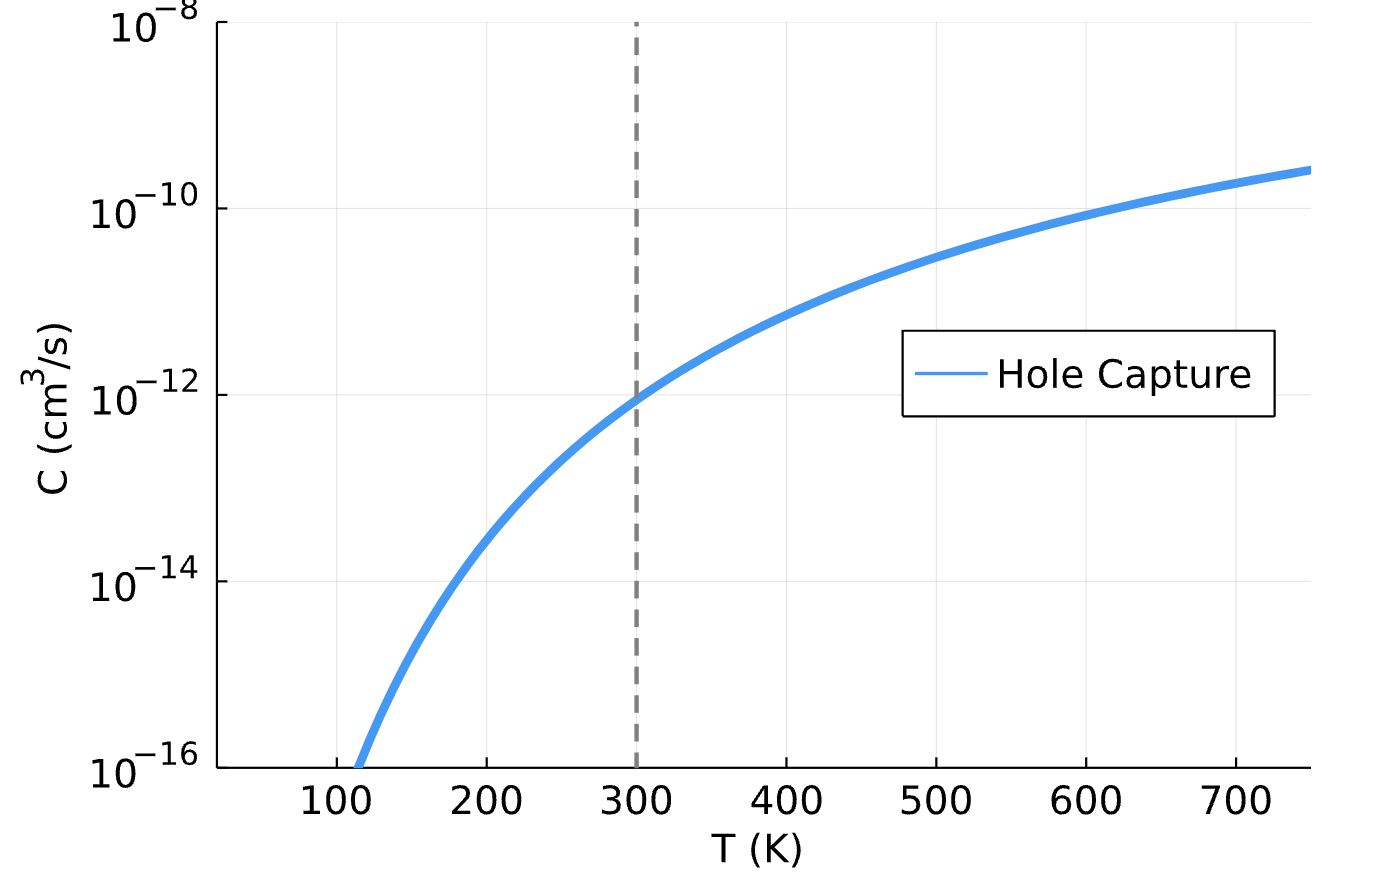

### Electron capture by $V_{Sb}^{+}$

In [ ]:
Q₀ = 0.6 * delQ
W_e = 0.01574121704013372 # e-ph coupling
g_e =  2 # degeneracy of the final state

# build a configuration coordinate for the electron capture
cc_e = conf_coord(pot1, pot2)
cc_e.W = W_e
cc_e.g = g_e
calc_overlap!(cc_e; cut_off = cut_off, σ = σ, Q₀ = Q₀)
calc_capt_coeff!(cc_e, Volume, temperature)

In [ ]:
plt = plot()
Plotter.plot_cc!(cc_e; plt=plt, label="Unscaled Electron Capture")

xlims!(1, 13)
ylims!(1E-10, 1E-7)

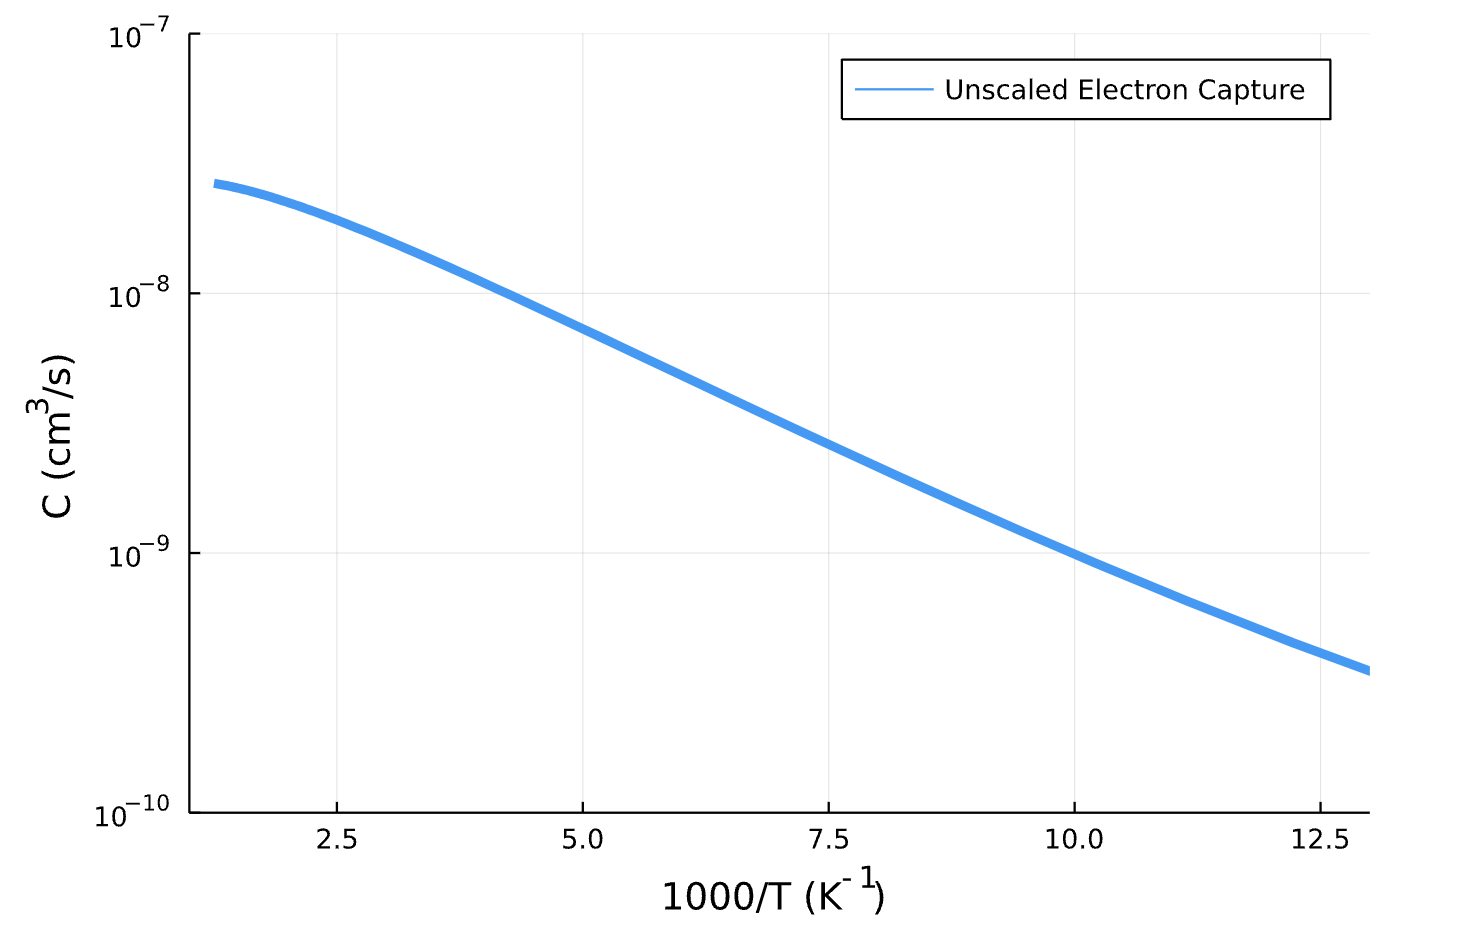

In [ ]:
sommerfeld_e_V_Sb_plus1 = [6.948898055578163, 5.239725729205172, 4.417162884440406, 3.9155057451525628, 3.571157867323164, 3.3171858029459464, 3.1205584558348463, 2.9628975068688908, 2.8330800995340075, 2.7239402674347786, 2.63063232000298, 2.549750430826425, 2.4788239227818223, 2.416012654114402, 2.359915183401068, 2.309443555518944, 2.2637390356887326, 2.222113882606023, 2.1840101754251195, 2.148970101983742, 2.1166141273597687, 2.0866246917464655, 2.058733859224848, 2.032713836240219, 2.0083696056476485, 1.9855331415977644, 1.9640588203825107, 1.9438197463893891, 1.924704785623039, 1.906616151632997, 1.8894674265914928, 1.8731819280206639, 1.8576913522162595, 1.8429346407824572, 1.828857028296029, 1.8154092379579028, 1.8025467988813153, 1.7902294639240226, 1.778420711073745, 1.7670873146180566, 1.7561989748775682, 1.7457279973084352, 1.7356490134027305, 1.7259387371211914, 1.7165757516497573, 1.7075403221308312, 1.6988142307228, 1.690380630918149, 1.682223918526285, 1.674329617121171, 1.6666842760815264, 1.659275379624856, 1.6520912654657505, 1.6451210519215893, 1.638354572451391, 1.6317823167511736, 1.6253953776460925, 1.6191854031191693, 1.6131445529015052, 1.607265459121687, 1.6015411905747772, 1.5959652202250938, 1.590531395603636, 1.585233911801242, 1.5800672867935754, 1.5750263388644217, 1.5701061659203221, 1.5653021265126585, 1.5606098224036513, 1.556025082530446, 1.5515439482371098, 1.5471626596581332, 1.5428776431491102, 1.5386854996710797, 1.5345829940444025, 1.5305670449965536, 1.526634715935641, 1.52278320638811, 1.5190098440450508, 1.5153120773667892, 1.511687468700179, 1.5081336878672376, 1.5046485061875763, 1.501229790900461, 1.4978754999553991, 1.4945836771429235, 1.4913524475396955, 1.4881800132443062, 1.4850646493821573, 1.482004700359674, 1.4789985763496756, 1.4760447499913376, 1.4731417532894315, 1.4702881746988539, 1.467482656381512, 1.4647238916237126, 1.4620106224030887, 1.4593416370949768, 1.4567157683089274, 1.4541318908467273]
scaling = 1 * sommerfeld_e_V_Sb_plus1

In [ ]:
using Plots
plt = plot(legendfontsize=12,legend=:right,yaxis = font(12),xaxis = font(12))
plot!(plt, 1000 ./ cc_e.temperature, cc_e.capt_coeff .* scaling, lw = 4,legend=:topright, label = "Scaled Electron Capture Coefficient")
xaxis!(L"\ 1000\/T (K^{-1}) \ (^{}$$"); yaxis!(L"C (cm^{3}\/s) \ (^{}$$", :log10)
xlims!(1, 20)
ylims!(1E-10, 1E-7)

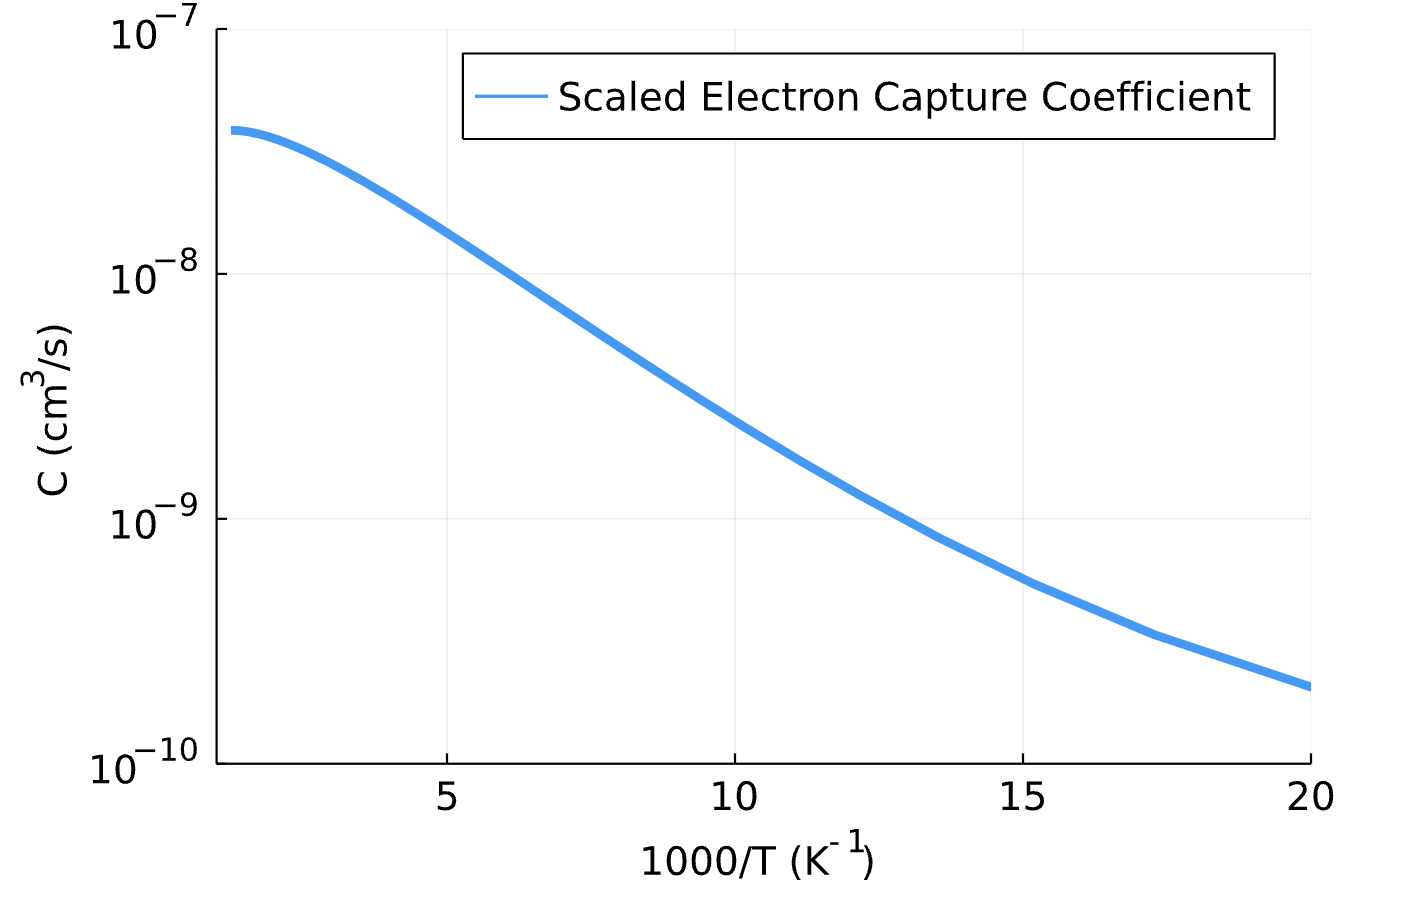

## 2.4 Capture cross section

Capture cross section is calculated by $\sigma$=𝐶/⟨𝑣⟩, where *C* is capture coefficient and *v* is thermal velocity.


In [ ]:
Boltzmann = 1.3806504e-23;                              # kg m^2 / K s^2 
MassElectron = 9.10938188e-31;                          # kg

In [ ]:
using Printf

m_e_Sb2Se3 = 0.35
m_h_Sb2Se3 = 0.90
T=300
v_e = sqrt(3*Boltzmann*T/(m_e_Sb2Se3*MassElectron))
v_h = sqrt(3*Boltzmann*T/(m_h_Sb2Se3*MassElectron)) 
@printf("Electron thermal velocity @ 300K in Sb2Se3: %.2e m/s\n", v_e)
@printf("Hole thermal velocity @ 300K in Sb2Se3: %.2e m/s", v_h)


In [ ]:
function velocity_at_T(m_eff, T)
           sqrt(3*Boltzmann*T/(m_eff*MassElectron))
       end

In [ ]:
plt = plot(legendfontsize=12,legend=:right,yaxis = font(12),xaxis = font(12))

plot!(plt, cc_h.temperature, cc_h.capt_coeff ./ (velocity_at_T.(m_h_Sb2Se3, cc_h.temperature).*100), # cm/s 
    lw = 4, label = "Hole Capture")
plot!(plt, cc_e.temperature, cc_e.capt_coeff .* sommerfeld_e_V_Sb_plus1 ./ (velocity_at_T.(m_e_Sb2Se3, cc_h.temperature).*100),
    lw = 4, label = "Electron Capture")
vline!(plt, [300], linestyle=:dash, lw=2,label=false,color=:grey)

xaxis!(L"\ T (K) \ (^{}$$");
ylims!(1E-25, 1E-14) 
yaxis!(L"\sigma (cm^{2}) \ (^{}$$", :log10)
xlims!(50, 750)

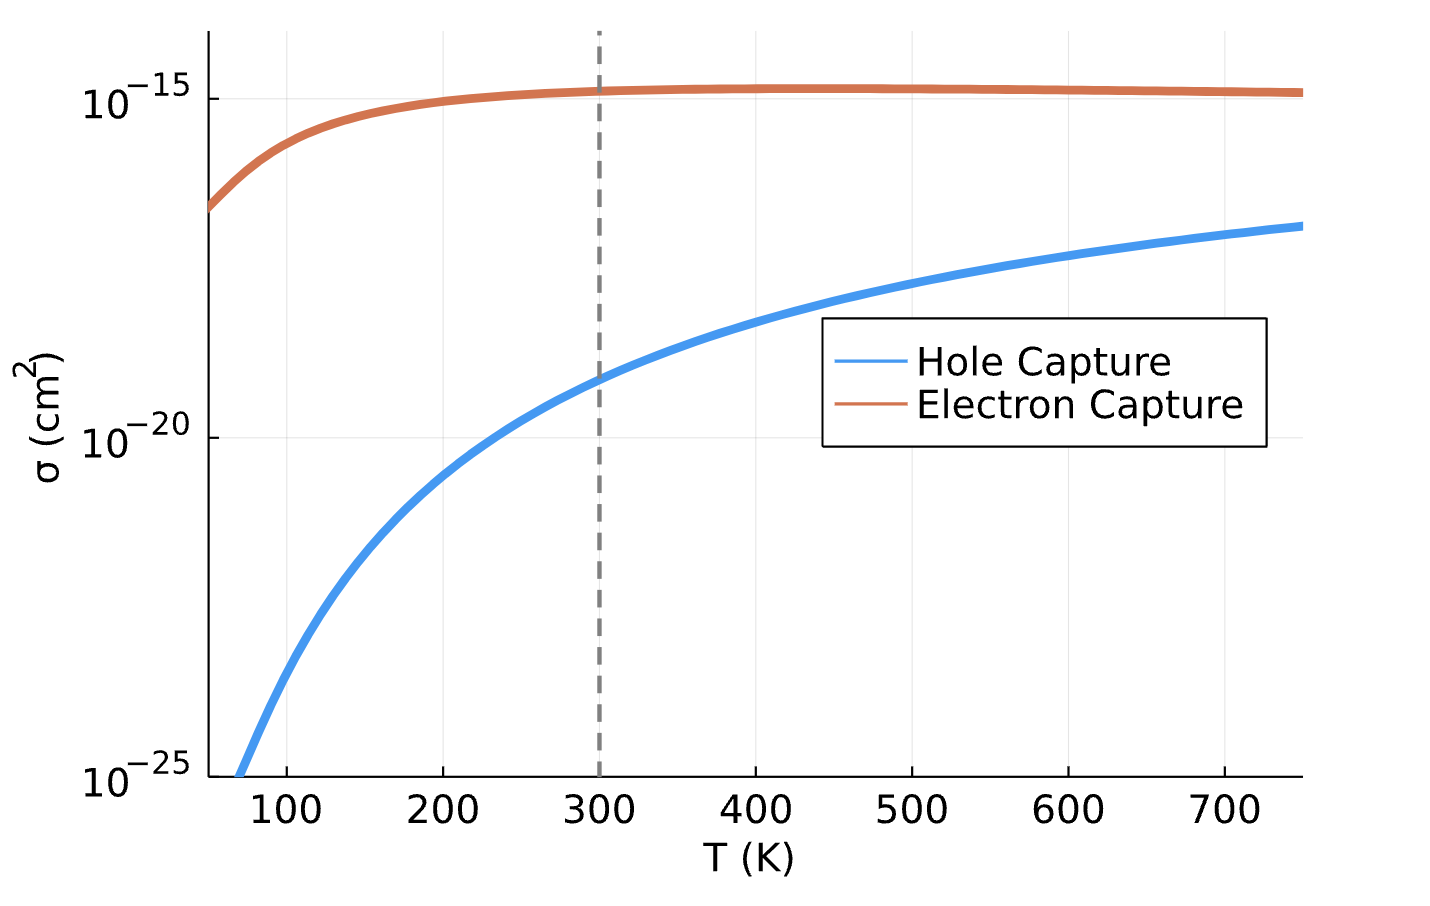